In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns
from ads_utils import load_data
import datetime

SMALL, MED, LARGE = 22, 28, 34
LW = 2
plt.rc('xtick',labelsize=SMALL)
plt.rc('ytick',labelsize=SMALL)

data = load_data(list(range(1, 25)))
break1, break2 = len(load_data(list(range(1, 13)))), len(load_data(list(range(1, 19))))

C:\Users\camch\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


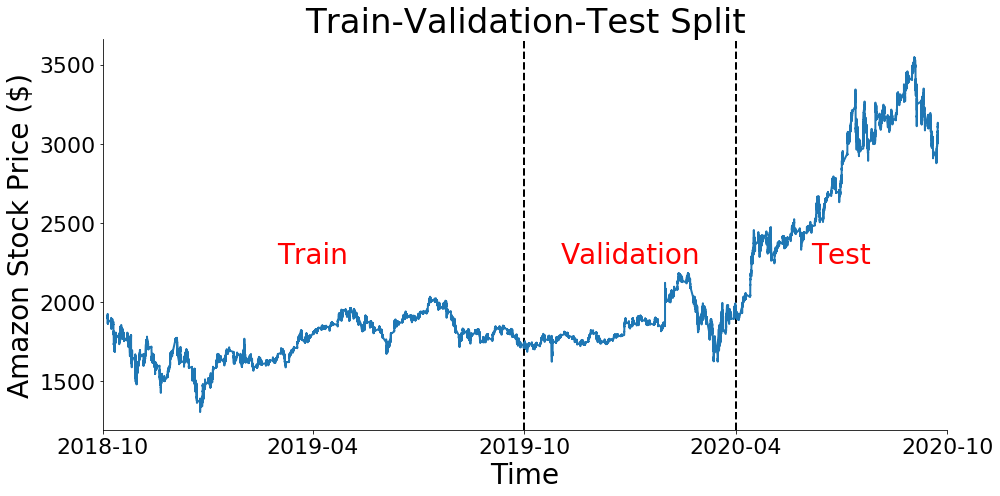

In [2]:
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(data.time, data.close, lw=LW)

ax.set_title('Train-Validation-Test Split', fontsize=LARGE)
ax.set_xlabel('Time', fontsize=MED)
ax.set_ylabel('Amazon Stock Price ($)', fontsize=MED)


ax.set_xticks([datetime.datetime(y,m,1) for y in [2018, 2019, 2020] for m in [10, 4]])
ax.set_xlim(datetime.datetime(2018,10,1), datetime.datetime(2020,10,1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  
plt.axvline(datetime.datetime(2019,10,1), color='black', lw=LW, zorder=-1, linestyle='--')  
plt.axvline(datetime.datetime(2020, 4,1), color='black', lw=LW, zorder=-1, linestyle='--')

ax.annotate('Train', xy=(datetime.datetime(2019,4,1), 2300), xytext=(0, 0), textcoords='offset points', 
            ha='center', va='center', color='red', fontsize=MED)
ax.annotate('Validation', xy=(datetime.datetime(2020,1,1), 2300), xytext=(0, 0), textcoords='offset points', 
            ha='center', va='center', color='red', fontsize=MED)
ax.annotate('Test', xy=(datetime.datetime(2020,7,1), 2300), xytext=(0, 0), textcoords='offset points', 
            ha='center', va='center', color='red', fontsize=MED)

plt.tight_layout()
sns.despine()
plt.savefig('TrainValTestSplit.png', dpi=2*fig.dpi)
plt.show()

In [3]:
wb = pd.read_csv('wandb.csv')
wb = wb[wb.State == 'finished'][['batch_size', 'learning_rate', 'n_ticks', 'portfolio_value']]
wb = wb.sort_values(['batch_size', 'learning_rate'], ascending=True)

heatmap_data = []
for batch_size in wb.batch_size.unique():
    heatmap_data.append(wb[(wb.batch_size==batch_size)].pivot(index='n_ticks',columns='learning_rate',values='portfolio_value'))

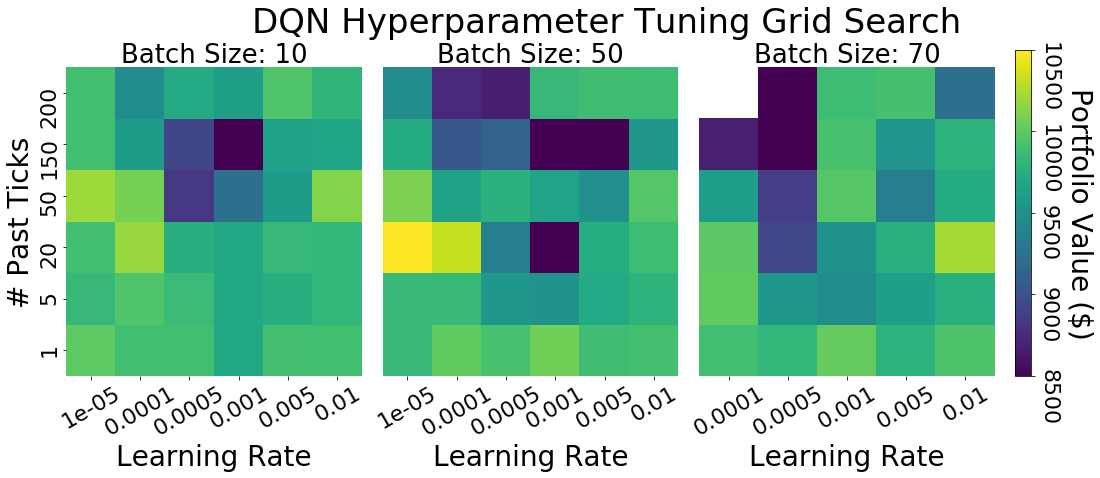

In [8]:
from matplotlib.cm import ScalarMappable

fig, ax = plt.subplots(ncols=len(wb.batch_size.unique()), figsize=(20, 6))
cmap = plt.get_cmap('viridis')
vmin, vmax = 8500, 10_500

for i, batch_size in enumerate(wb.batch_size.unique()):
    sns.heatmap(heatmap_data[i], vmin=vmin, vmax=vmax, cmap=cmap, ax=ax[i], cbar=False)
    ax[i].invert_yaxis()
    ax[i].set_xlabel('Learning Rate', fontsize=MED)
    for label in ax[i].get_xticklabels():
        label.set_rotation(30)
    
    if i != 0:
        ax[i].set_yticks([], [])
        ax[i].set_ylabel('')
    
ax[0].set_ylabel('# Past Ticks', fontsize=MED)
            
pad = 5

for a, col in zip(ax, [f'Batch Size: {batch_size}' for batch_size in wb.batch_size.unique()]):
    a.annotate(col, xy=(0.5, 1), xytext=(0, pad),
               xycoords='axes fraction', textcoords='offset points',
               size=MED-2, ha='center', va='baseline')
    
norm = plt.Normalize(vmin, vmax)
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.ax.tick_params(labelsize=SMALL, rotation=-90) 
cbar.set_label('Portfolio Value ($)', fontsize=MED, rotation=270, labelpad=35)

plt.subplots_adjust(wspace=0.07, hspace=0.07, right=0.77, top=0.84)

fig.suptitle('DQN Hyperparameter Tuning Grid Search', fontsize=LARGE)

plt.savefig('DQN Hyperparameters.png', dpi=2*fig.dpi, bbox_inches = "tight")
plt.show()

In [20]:
heatmap_data = {}
for i, gamma in enumerate(wb.gamma.unique()):
    for j, n_steps in enumerate(wb.n_steps.unique()):
        heatmap_data[(i, j)] = wb[(wb.n_steps == n_steps) & (wb.gamma == gamma)].pivot(index='momentum', 
                                                                                       columns='learning_rate',
                                                                                       values='portfolio_value')

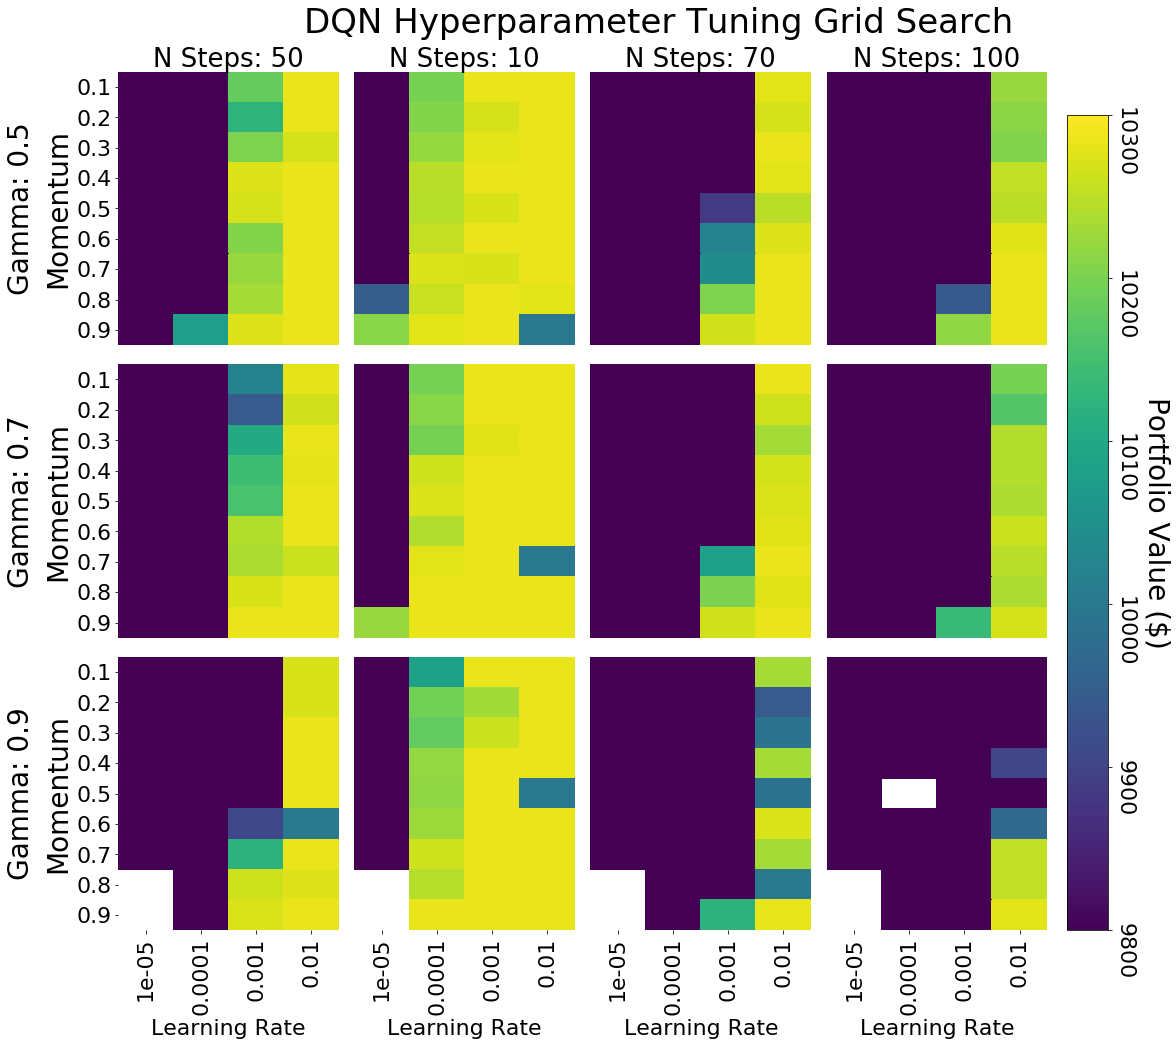

In [87]:
from matplotlib.cm import ScalarMappable

fig, ax = plt.subplots(nrows=len(wb.gamma.unique()), ncols=len(wb.n_steps.unique()), figsize=(20, 15))
cmap = plt.get_cmap('viridis')
vmin, vmax = 9800, 10_300


for i, gamma in enumerate(wb.gamma.unique()):
    for j, n_steps in enumerate(wb.n_steps.unique()):
        sns.heatmap(heatmap_data[(i, j)], vmin=vmin, vmax=vmax, cmap=cmap, ax=ax[i][j], cbar=False)
                    
        if i == len(wb.gamma.unique()) - 1:
            ax[i][j].set_xlabel('Learning Rate', fontsize=SMALL)
        else:
            ax[i][j].set_xlabel('')
            ax[i][j].set_xticks([], [])
            
        if j == 0:
            ax[i][j].set_ylabel('Momentum', fontsize=MED)
        else:
            ax[i][j].set_ylabel('')
            ax[i][j].set_yticks([], [])
            
pad = 5

for a, col in zip(ax[0], [f'N Steps: {n_steps}' for n_steps in wb.n_steps.unique()]):
    a.annotate(col, xy=(0.5, 1), xytext=(0, pad),
               xycoords='axes fraction', textcoords='offset points',
               size=MED-2, ha='center', va='baseline')

for a, row in zip(ax[:,0], [f'Gamma: {gamma}' for gamma in wb.gamma.unique()]):
    a.annotate(row, xy=(0, 0.5), xytext=(-a.yaxis.labelpad - pad, 0),
               xycoords=a.yaxis.label, textcoords='offset points',
               size=MED, ha='right', va='center', rotation=90)
    
norm = plt.Normalize(vmin, vmax)
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.ax.tick_params(labelsize=SMALL, rotation=-90) 
cbar.set_label('Portfolio Value ($)', fontsize=MED, rotation=270, labelpad=35)

plt.subplots_adjust(wspace=0.07, hspace=0.07, right=0.77, top=0.92)

fig.suptitle('DQN Hyperparameter Tuning Grid Search', fontsize=LARGE)

plt.show()

In [ ]:
from matplotlib.cm import ScalarMappable

multi_classs = ['ovr', 'multinomial']
solvers = ['newton-cg', 'lbfgs', 'sag', 'saga']
Cs = [10**power for power in range(-2, 5)]
tols = [10**power for power in range(-5, 2)]

plot = load_obj('plot')

fig, ax = plt.subplots(nrows=len(solvers), ncols=len(multi_classs), sharex=True, sharey=True, figsize=(10, 15))
cmap = plt.get_cmap("viridis")
vmin, vmax = min([min(v) for v in plot.values()]), max([max(v) for v in plot.values()])

for i, multi_class in enumerate(multi_classs):
    for j, solver in enumerate(solvers):
        ax[j][i].scatter(sorted(Cs*len(tols)), tols*len(Cs), 
                         cmap=cmap, c=plot[multi_class+solver], marker='s', s=1100, vmin=vmin, vmax=vmax)
        ax[j][i].set_xlim(min(Cs)*10**(-0.5), max(Cs)*10**0.5)
        ax[j][i].set_ylim(min(tols)*10**(-0.5), max(tols)*10**0.5)
        ax[j][i].set_xscale('log')
        ax[j][i].set_yscale('log')
        ax[j][i].tick_params(axis='both', which='major', labelsize=SMALL-1)
        ax[j][i].set_xlabel('C', fontsize=INBTWN)
        ax[j][i].set_ylabel('Tolerance', fontsize=INBTWN)
        ax[j][i].set_xticks(Cs)
        ax[j][i].set_yticks(tols)
        
cols = ['MultiClass: {}'.format(multi_class) for multi_class in multi_classs]
rows = ['Solver: {}'.format(solver) for solver in solvers]

#plt.setp(ax.flat, xlabel='C', ylabel='Tolerance', labelsize=SMALL)
pad = 5

for a, col in zip(ax[0], cols):
    a.annotate(col, xy=(0.5, 1), xytext=(0, pad),
               xycoords='axes fraction', textcoords='offset points',
               size=MED-2, ha='center', va='baseline')

for a, row in zip(ax[:,0], rows):
    a.annotate(row, xy=(0, 0.5), xytext=(-a.yaxis.labelpad - pad, 0),
               xycoords=a.yaxis.label, textcoords='offset points',
               size=MED, ha='right', va='center', rotation=90)

fig.suptitle('Logistic Regression Hyperparameter Tuning', fontsize=LARGE)
fig.tight_layout()
fig.subplots_adjust(left=0.2, right=0.95, top=0.93)
        
norm = plt.Normalize(vmin, vmax)
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.ax.tick_params(labelsize=MED, rotation=-90) 
cbar.ax.set_title('Accuracy', fontsize=MED)

plt.savefig('Logistic Hyperparameters.png')
plt.show()